# CS 525 Assignment 1 spring 2023

### Machine learning for protein sequence data

In this assignment you will explore some of the traditional approaches for modeling sequence data with machine learning using feature representations based on amino acid composition.  Our data will come from the SCOP database, which is a curated repository of proteins classified according to the overall characteristics of their 3-d structure.  We will explore how well this information can be predicted from the amino acid sequence.

The primary tool we will use is the k-mer composition vector, which represents a protein in the space of all k-mers of length $k$.


### Preliminaries:  data

In this assignment you will create classifiers that predict the SCOP family a sequence belongs to.  The [SCOP database](https://scop.mrc-lmb.cam.ac.uk/) classifies sequences into families based on the characteristics of their 3-d structure.  The identifier of a SCOP family has four component, and is of the form **w.x.y.z**, representing the class.fold.superfamily.family levels of organization in SCOP (e.g. b.1.1.0).
These four levels of classification used by SCOP are:  
* family:  a group of closely related proteins
* superfamily:  groups together several families of proteins that likely share a common evolutionary origin
* fold:  groups together superfamilies based on structural properties
* class:  combine folds with common secondary secondary structure.  These include all-alpha and all-beta proteins, containing predominantly alpha-helices and beta-strands, respectively, and ‘mixed’ alpha and beta classes (a/b) and (a+b) with respectively alternating and segregated alpha-helices and beta-strands.

In your experiments you will focus on two very large families: 'b.1.1.0' and 'b.1.1.1' which are "all beta proteins" (hence the "b").  Both families belong to the b.1.1 immunoglobulin superfamily of immune system proteins.  You can obtain the sequences from the following [fasta file](https://scop.berkeley.edu/downloads/scopeseq-2.08/astral-scopedom-seqres-gd-sel-gs-bib-95-2.08.fa) containing the sequences in version 2.08 of SCOP, processed to contain a non-redundant set of sequences such that no two sequences share more than 95% sequence identity.


### Part 1:  initial explorations with SVMs

Like many machine learning techniques, SVMs can be applied in different ways by varying the kernel and hyperparameters as well as the feature pre-processing.  We will do this for a fixed value of the k-mer size, $k=3$.  After we have found good choices for the kernel and pre-processing, we will explore performance as a function of $k$.


#### Preprocessing

Like other weight-vector based classifiers, SVMs benefit from preprocessing the data appropriately.  Since k-mer composition data is sparse, standardization is not a good option.  Instead, compare the accuracy of a linear SVM evaluated on the raw k-mer count features with a feature matrix constructed by normalizing each feature vector into a unit vector.  This is done by dividing each row in the feature matrix by its norm.
Classifier hyper-parameters should be chosen using grid search on the training data.
Use the best performing preprocessing for the rest of your experiments.

<span style="color:lightgreen">

### Functions and Imports 

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from Bio import SeqIO
import itertools
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#Takes a path to a fasta file and parses it.
#Pre-Input Data:    Data Path
#Return Data:       A DataFrame consisting of the Sequence ID, Family, 
#                   and whole sequence, hardcoded to filter down to 
#                   the two families in question (b.1.1.0 & b.1.1.1)
def BuildMatrixFromFasta(dataPath):

    dfColumns = [['SeqID', 'SeqFam', 'Seq']]
    dataMatrix = np.empty((0,3), dtype=object)

    for seq in SeqIO.parse(open(dataPath), 'fasta'):
        family = GetSeqFamily(seq.description)
        line = [[seq.id, family, seq.seq]]
        if ((family == 'b.1.1.0' or family == 'b.1.1.1') and "x" not in seq.seq):
            dataMatrix = np.append(dataMatrix, line, axis=0)

    df = pd.DataFrame(dataMatrix, columns=dfColumns, dtype=object)

    return df

#Takes a sequence descriptor from SeqIO iterator and trims whitespace
#Pre-Input Data:    A string consisting of a sequence family ID
#Return Data        A string consisting of only the sequence family ID (no whitespace)    
def GetSeqFamily(desc):
    firstWhiteSpace = desc.index(' ') + 1
    secondWhiteSpace = desc[firstWhiteSpace:].index(' ') + firstWhiteSpace
    return desc[firstWhiteSpace:secondWhiteSpace] 


#Takes an integer input and builds a matrix consisting of every possible combination
#of amino acids when paired in groups of k
#Pre-Input Data:    Integer
#Return Data:       A numpy array with columns equal to the total pairwise
#                   combinations of all groupings of k amino acids. 
def BuildKmerMatrix(k):

    kMatrix = []
    curCombo = ""
    lastCombo = ""

    aa = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

    iter = list(itertools.product(aa, repeat=k))
    for item in iter:
        if len(curCombo)>0:
            kMatrix.append([curCombo])
            curCombo = ""
        for aa in item:
            curCombo += aa


    for i in range(k):
        lastCombo += aa[-1] 

    kMatrix.append([lastCombo])
    kMatrix = np.array(kMatrix)
    shape = kMatrix.shape
    kMatrix = np.reshape(kMatrix, (shape[1], shape[0]))

    return kMatrix


#Takes a sequence, index, integer, and DataFrame to find the total number of grouped
#kMers in a given sequence.
#Pre-Input Data:    A sequence of amino acids as a concatted string.
#                   An index indicating which row of a dataframe to update
#                   An integer corresponding to the length of amino acid groupings (kmers)
#                   A DataFrame consisting of the columns of pairwise combinations of all kmers
#Return Data:       Returns 0. Updates the DataFrame in place with all found kmers.
def FindKMers(seq, index, k, df):

    for i in range(len(seq)):
        curKmer = ""
        if (i+k >= len(seq)):
            curKmer = seq[i:]
            curKmer = curKmer.upper()
            df.at[index, curKmer] += 1
            break
        else:
            curKmer = seq[i:i+k]
            curKmer = curKmer.upper()
            #print(curKmer)
            df.at[index, curKmer] += 1

    return 0

#Takes an integer input and builds a matrix consisting of every possible combination
#of amino acids groups when paired in groups of k
#Pre-Input Data:    Integer
#Return Data:       A numpy array with columns equal to the total pairwise
#                   combinations of all groupings of k amino acid groups.
def BuildTypeKmerMatrix(k):

    kMatrix = []
    curCombo = ""
    lastCombo = ""

    aaGroup = ['Cys', 'Pol', 'Pos', 'Neg', 'Pho', 'Aro']

    iter = list(itertools.product(aaGroup, repeat=k))
    for item in iter:
        if len(curCombo)>0:
            kMatrix.append([curCombo])
            curCombo = ""
        for aa in item:
            curCombo += aa

    for i in range(k):
        lastCombo += aaGroup[-1] 

    kMatrix.append([lastCombo])
    kMatrix = np.array(kMatrix)
    shape = kMatrix.shape
    kMatrix = np.reshape(kMatrix, (shape[1], shape[0]))

    return kMatrix

#Python doesn't have switch statements...
#Takes an amino acid and assigns it a provided group.
#Pre-Input Data:    A single character (string) amino acid
#Returns Data:      A string label corresponding to the group the amino acid belongs to.        
def GetAAGroup(aa):

    aaGroup = ['Cys', 'Pol', 'Pos', 'Neg', 'Pho', 'Aro']

    if(aa == 'c'):
        return aaGroup[0]
    elif(aa == 's' or aa == 't' or aa == 'a' or aa == 'g' or aa == 'p'):
        return aaGroup[1]
    elif(aa == 'h' or aa == 'r' or aa == 'k'):
        return aaGroup[2]
    elif(aa == 'd' or aa == 'e' or aa == 'n' or aa == 'q'):
        return aaGroup[3]
    elif(aa == 'm' or aa == 'i' or aa == 'l' or aa == 'v'):
        return aaGroup[4]
    else:
        return aaGroup[5]

#Takes a sequence, index, integer, and DataFrame to find the total number of grouped
#kMers in a given sequence.
#Pre-Input Data:    A sequence of amino acids as a concatted string.
#                   An index indicating which row of a dataframe to update
#                   An integer corresponding to the length of amino acid groupings (kmers)
#                   A DataFrame consisting of the columns of pairwise combinations of all kmer aa groups
#Return Data:       Returns 0. Updates the DataFrame in place with all found kmers of aa groups.
def FindTypeKmers(seq, index, k, df):

    for i in range(len(seq)):
        curKmer = ""
        curGroup = ""
        if (i+k >= len(seq)):
            curKmer = seq[i:]
            for aa in curKmer:
                curGroup += GetAAGroup(aa) 
            df.at[index, curGroup] += 1
            break
        else:
            curKmer = seq[i:i+k]
            for aa in curKmer:
                curGroup += GetAAGroup(aa)
            df.at[index, curGroup] += 1

    return 0

#Takes in a dataframe matrix and standardizes by normalization each row.
#Pre-Input Data:    An unstandardized data matrix consisting of kmer counts
#Return Data:       Returns the standardized matrix.
def NormMatrix(data):

    curNorm = 0

    for i in range(data.shape[1]):
        curNorm = np.linalg.norm(data.iloc[:,i], axis=0)
        if (curNorm > 0):
            data.iloc[:,i] /= curNorm

    return data

#A pipeline function that takes in a feature matrix of kmers, a name, an integer, and a data matrix
#Pre-Input Data:    A feature matrix consisting of only columns of kmers (AA's or AA groups)
#                   A name for the data frame. If "Group" is present it will assume a matrix with kmer aa groups
#                   An integer which is in turn only used to feed into FindKmer Functions. Used to determine kmer length
#                   A data matrix consisting of at least Sequences and Sequence Families [Seq] and [SeqFam]
#Return Data:       A final DataFrame consisting of all input samples with feature columns of Sequence, Sequence Family, 
#                   and all found kmers (whether aa groups or aa)
def BuildFinalMatrix(kMerMatrix, dfname, k, data):
    matrixCols = np.array(['SeqFam', 'Seq'])
    kMerCols = np.array(kMerMatrix[0])
    matrixCols = np.hstack((matrixCols, kMerCols))\
    
    finalDF = pd.DataFrame(columns=matrixCols)
    finalDF['SeqFam'] = data['SeqFam']
    finalDF['Seq'] = data['Seq']
    finalDF.replace(np.nan, 0, inplace=True)

    curIndex = 0
    print("Building " + str(dfname) + " final DataFrame...")

    if("Group" in dfname):
        for seq in finalDF['Seq']:
            FindTypeKmers(seq, curIndex, k, finalDF)
            curIndex += 1
    else:
        for seq in finalDF['Seq']:
            FindKMers(seq, curIndex, k, finalDF)
            curIndex +=1

    return finalDF

#Takes the final dataframe matrix spit out from BuildFinalMatrix and splits the data into two even partitions of
#the groups in question (b.1.1.1, b.1.1.0), randomly sampling from each group. 
#Pre-Input Data:    A final dataframe returned from BuildFinalMatrix
#                   An integer representing total number of samples to sample.
#Return Data:       A smaller matrix (i x k, where k = features of the matrix supplied) 
#                   with a randomly sampled subset of the two groups in equal proportion. 
def ShuffleAndSampleMatrix(matrix, i):

    group1 = matrix[:][matrix['SeqFam'] == 'b.1.1.1']
    group2 = matrix[:][matrix['SeqFam'] == 'b.1.1.0']

    group1 = group1.iloc[:,2:]
    group2 = group2.iloc[:,2:]

    group1 = np.array(group1)
    group2 = np.array(group2)

    random.shuffle(group1)
    random.shuffle(group2)

    group1 = group1[:int((i/2))]
    group2 = group2[:int((i/2))]

    totalMatrix = np.vstack((group1, group2))

    return totalMatrix


In [2]:
#Expected Cell Runtime ~15 seconds
#Parse data from the SCOP database
data = BuildMatrixFromFasta('SCOP.fa')
#Build the feature Matrix Columns
featureMatrixCols = BuildKmerMatrix(3)
#Build the final matrix, combining seq and seqfam columns with a populated feature matrix
finalDF = BuildFinalMatrix(featureMatrixCols, 'Final', 3, data)

finalDF

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Building Final final DataFrame...


,SeqFam,Seq,AAA,AAR,AAN,AAD,AAC,AAE,AAQ,AAG,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
0,b.1.1.1,"(h, v, r, g, v, t, v, r, m, e, t, p, e, a, i, ...",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,b.1.1.1,"(v, q, l, q, a, s, g, g, g, s, v, q, a, g, q, ...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b.1.1.1,"(v, q, l, q, a, s, g, g, g, s, v, q, a, g, g, ...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b.1.1.1,"(v, q, l, v, e, s, g, g, g, t, v, p, a, g, g, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b.1.1.1,"(q, v, q, l, v, e, s, g, g, g, s, v, q, a, g, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,b.1.1.0,"(m, q, v, q, l, v, e, t, g, g, g, l, v, q, p, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3824,b.1.1.0,"(v, q, l, a, e, s, g, g, g, l, v, q, p, g, g, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3825,b.1.1.0,"(m, q, l, q, l, v, e, s, g, g, g, l, v, q, a, ...",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3826,b.1.1.0,"(m, q, l, q, l, v, e, s, g, g, g, l, v, q, a, ...",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Expected Cell Runtime ~1 minute
#ParamGrid values with which to use GridSearch on. 
param_grid = [
  {'C': [0.001, 0.01, 0.1, 1, 10], 
   'kernel': ['linear']},
 ]

#Verifying finalDF shape 'makes sense'
print(finalDF.shape)

#Strip away the feature matrix for X inputs and the target SeqFam data for Y
X = finalDF.iloc[:,2:-1]
Y = finalDF['SeqFam']

#Verifying the shapes of X and Y make sense.
print(X.shape)
print(Y.shape)

#Train test split the data.
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=42)

#Stripping away the feature matrix to be normalized.
normX = finalDF.iloc[:,2:-1]
normX = NormMatrix(normX)

#Norm data train test split, note targets are unaffected (Y stays the same)
n_trainX, n_testX, n_trainY, n_testY = train_test_split(normX, Y, test_size=0.3, random_state=42)

# #GridSearch SVM on normalized and un-normalized data.
# SVMLinear = GridSearchCV(svm.SVC(), param_grid)
# SVMLinear.fit(trainX, trainY)
# print(SVMLinear.best_estimator_)
# print(SVMLinear.best_params_)
# print(SVMLinear.cv_results_['mean_test_score'])

# SVMLinearNorm = GridSearchCV(svm.SVC(), param_grid)
# SVMLinearNorm.fit(n_trainX, n_trainY)
# print(SVMLinearNorm.best_estimator_)
# print(SVMLinearNorm.best_params_)
# print(SVMLinearNorm.cv_results_['mean_test_score'])

#Running SVMs on established data from the gridsearch outputs. GridSearch will remain commented in final submission due to runtime. 
SVMLinear = svm.SVC(kernel="linear", C=0.01)
SVMLinear.fit(trainX, trainY)
y_pred = SVMLinear.predict(testX)
print('SVM Linear Unnormalized \t', np.mean(testY == y_pred))

SVMLinear_norm = svm.SVC(kernel='linear', C=1)
SVMLinear_norm.fit(n_trainX, n_trainY)
y_pred = SVMLinear_norm.predict(n_testX)
print('SVM Linear Normalized \t\t', np.mean(n_testY == y_pred))


(3828, 8002)
(3828, 7999)
(3828,)
SVM Linear Unnormalized 	 0.834638816362054
SVM Linear Normalized 		 0.8259355961705831


#### Saved Outputs from Above Cell

(3828, 8002)

(3828, 7999)

(3828,)

SVC(C=0.01, kernel='linear')

{'C': 0.01, 'kernel': 'linear'}

SVC(C=1, kernel='linear')

{'C': 1, 'kernel': 'linear'}



SVM Linear Unnormalized 	 0.834638816362054

SVM Linear Normalized 		 0.8259355961705831

<span style="color:lightgreen">

### Preprocessing Discussion

Two SVM's were trained using GridSearch on the param_grid variable listed at the top of the above cell. The conclusion was that, while the unnormalized data performed slightly better, the effect is essentially neglidgible with slightly less than a 1% difference. Likely this is due to the sparseness of the feature matrix. With 8000 features, each 3mer likely only appears a handfull of times meaning feature columns will *typically* range from 0 - 1 anyway. Normalizing down to a float between 0 - 1 on an already sparse data matrix that has low values just doesn't impact the data that much. 

The classifier and data combination moving forward from this step is a Linear SVM using unnormalized data and hyper paremeter C=0.01. 


#### Accuracy using linear and Gaussian kernels

Compute SVM accuracy for a linear and Gaussian kernel for a k-mer composition representation with $k=3$.  Classifier hyper-parameters should be chosen using grid search on the training data.
Is there a kernel that seems to work better?  Use it for the rest of your experiments.
Finally, compare your SVM results with a random forests classifier.

In [4]:
#Expected Cell Runtime ~2 minutes
#Paramgrid to use GridSearch for determining which has better accuracy, RBF or Linear and under what hyperparameters
param_grid = [
  {'C': [0.001, 0.01, 0.1, 1, 10], 
   'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 
   'kernel': ['linear', 'rbf']},
 ]

#Small paramgrid to use GridSearch for determining some hyperparameter tuning for RandomForest. Not an ideal spread, but likely better than default values. 
RFparam_grid = [
{
 'max_depth': [10, 50, 100],
 'n_estimators': [200, 800, 1600]}
]

# #GridSearch SVM and RandomForest on unnormalized data
# SVMSearch = GridSearchCV(svm.SVC(), param_grid)
# SVMSearch.fit(n_trainX, n_trainY)
# print(SVMSearch.best_estimator_)
# print(SVMSearch.best_params_)
# print(SVMSearch.cv_results_['mean_test_score'])

# RFSearch = GridSearchCV(RandomForestClassifier(), RFparam_grid)
# RFSearch.fit(n_trainX, n_trainY)
# print(RFSearch.best_estimator_)
# print(RFSearch.best_params_)
# print(RFSearch.cv_results_['mean_test_score'])

#Train test split the data.
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=42)

#Running SVMs on established data from the gridsearch outputs. GridSearch will remain commented in final submission due to runtime. 
SVMLinear = svm.SVC(kernel="linear", C=0.01)
SVMLinear.fit(trainX, trainY)
y_pred = SVMLinear.predict(testX)
print('SVM Linear: \t', np.mean(testY == y_pred))

#Something interesting is happening here. The GridSearch returns C=10 as the best value for that hyperparameter,
#However, it performs ~1.5% worse than C=1...
SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX, trainY)
y_pred = SVMRBF.predict(testX)
print('SVM RBF: \t', np.mean(testY == y_pred))

rft = RandomForestClassifier(max_depth=100, n_estimators=1600)
rft.fit(trainX, trainY)
y_pred = rft.predict(testX)
print('Random Forest: ' + '\t' + str(np.mean(testY == y_pred)))



SVM Linear: 	 0.834638816362054
SVM RBF: 	 0.845082680591819
Random Forest: 	0.8424717145343777


#### Saved Outputs from Above Cell

SVC(C=10, gamma=0.01)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

RandomForestClassifier(max_depth=100, n_estimators=1600)

{'max_depth': 100, 'n_estimators': 1600}

SVM Linear: 	 0.834638816362054

SVM RBF: 	 0.845082680591819

Random Forest: 	0.8442123585726719

<span style="color:lightgreen">

### Part 1 Discussion:



First an SVM was trained using GridSearch and the param_grid variable at the top of the previous cell. This param_grid (unlike the previous) included a non-linear 'rbf' kernal and a larger spread of C values with the inclusion of Gamma values. The result of the GridSearch was a C value of 10 and a Gamma of 0.01. Then a Linear and Non-Linear SVM were run and their accuracies compared. Interestingly, the GridSearch failed to return the correct best value for the hyperparameter in the gaussian kernal as C=1 performs slightly better, edging out the Linear kernal slightly. Then, as a baseline, both were compared against a RandomForest which also had a limited GridSearch of hyperparemeters. The RandomForest performed similarly both the Linear and non-linear SVMs, with all three being withing about ~1% accuracy. Still, RBF slightly outperformed (although this is probably well within the margin of error of the random seed) and thus the RBF SVM classifier will be used moving forward in the analyses. 

### Part 2:  performance as a function of k-mer size

Compute the accuracy of your chosen kernel/preprocessing combination as a function of the k-mer size, $k$.

What is the dimensionality of the feature matrix as you increase the k-mer size $k$?  What is the best value?  Explain why performance first increases with increasing $k$, but then begins to degrade.
For each value of $k$, compute the dot-product matrix and visualize it.  For a dataset with $N$ training examples, this will be an $N \times N$ matrix.  Before computing the matrix, make sure the data is ordered according to the class labels.  What patterns do you observe, and can that help you in understanding the performance of the resulting SVMs?

In [5]:
#Expected Runtime: ~5 minutes
#reparse data from the SCOP database (just to have it in this cell)
data = BuildMatrixFromFasta('SCOP.fa')

#Build all the kMer matrices for amino acid combinations. 1mer was included to give a larger range since 5mers (20^5) take prohibitively long to run.
oneMerMatrix = BuildKmerMatrix(1)
twoMerMatrix = BuildKmerMatrix(2)
threeMerMatrix = BuildKmerMatrix(3)
fourMerMatrix = BuildKmerMatrix(4)

#Build all the kMer matrices for amino acid GROUP combinations. 1mer to 6mer included since reduced alphabet encoding allows for greater range of kMer calculation. 
oneMerGroupMatrix = BuildTypeKmerMatrix(1)
twoMerGroupMatrix = BuildTypeKmerMatrix(2)
threeMerGroupMatrix = BuildTypeKmerMatrix(3)
fourMerGroupMatrix = BuildTypeKmerMatrix(4)
fiveMerGroupMatrix = BuildTypeKmerMatrix(5)
sixMerGroupMatrix = BuildTypeKmerMatrix(6)

#Build 1mer Final DataFrame
finalOneMerDF = BuildFinalMatrix(oneMerMatrix, '1mer', 1, data)

#Build 2mer Final DataFrame
finalTwoMerDF = BuildFinalMatrix(twoMerMatrix, '2mer', 2, data)

#Build 3mer Final DataFrame
finalThreeMerDF = BuildFinalMatrix(threeMerMatrix, '3mer', 3, data)

#Build 4mer Final DataFrame.
finalFourMerDF = BuildFinalMatrix(fourMerMatrix, '4mer', 4, data)

#Build 1mer Group Final DataFrame
finalOneMerGroupDF = BuildFinalMatrix(oneMerGroupMatrix, '1mer Group', 1, data)

#Build 2mer Group Final DataFrame
finalTwoMerGroupDF = BuildFinalMatrix(twoMerGroupMatrix, '2mer Group', 2, data)

#Build 3mer Group Final DataFrame
finalThreeMerGroupDF = BuildFinalMatrix(threeMerGroupMatrix, '3mer Group', 3, data)

#Build 4mer Group Final DataFrame
finalFourMerGroupDF = BuildFinalMatrix(fourMerGroupMatrix, '4mer Group', 4, data)

#Build 5mer Group Final DataFrame
finalFiveMerGroupDF = BuildFinalMatrix(fiveMerGroupMatrix, '5mer Group', 5, data)

#Build 6mer Group Final DataFrame
finalSixMerGroupDF = BuildFinalMatrix(sixMerGroupMatrix, '6mer Group', 6, data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Building 1mer final DataFrame...
Building 2mer final DataFrame...
Building 3mer final DataFrame...
Building 4mer final DataFrame...
Building 1mer Group final DataFrame...
Building 2mer Group final DataFrame...
Building 3mer Group final DataFrame...
Building 4mer Group final DataFrame...
Building 5mer Group final DataFrame...
Building 6mer Group final DataFrame...


SVM RBF 1mer Data: 	 0.7972149695387293
SVM RBF 2mer Data: 	 0.8398607484769365
SVM RBF 3mer Data: 	 0.845082680591819


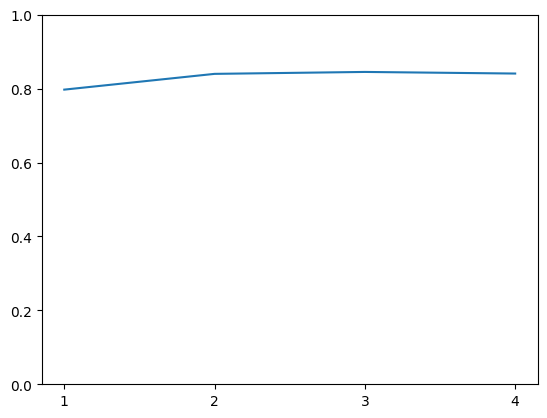

In [6]:
#Estimated Cell Runtime ~20 minutes (4mer alone 15 minutes to run. To save time, try commenting out.)

#Stripping away feature matrix for X input and the target matrix for y input. Grouped by kMer and data encoding type
X_1 = finalOneMerDF.iloc[:,2:-1]
X_2 = finalTwoMerDF.iloc[:,2:-1]
X_3 = finalThreeMerDF.iloc[:,2:-1]
X_4 = finalFourMerDF.iloc[:,2:-1]
Y = finalOneMerDF['SeqFam']

#Train test splits for all the standard amino acid encoded kmer compositions.
trainX1, testX1, trainY1, testY1 = train_test_split(X_1, Y, test_size=0.3, random_state=42)
trainX2, testX2, trainY2, testY2 = train_test_split(X_2, Y, test_size=0.3, random_state=42)
trainX3, testX3, trainY3, testY3 = train_test_split(X_3, Y, test_size=0.3, random_state=42)
trainX4, testX4, trainY4, testY4 = train_test_split(X_4, Y, test_size=0.3, random_state=42)

#Initialize an empty list to track accuracy of classifiers for plotting
accuracy = list()
xAx = [1, 2, 3, 4]
xTicks = range(len(xAx))

#Training and predicting standard amino acid composition SVM classifiers. 
SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX1, trainY1)
y_pred = SVMRBF.predict(testX1)
accuracy.append(np.mean(testY1 == y_pred))
print('SVM RBF 1mer Data: \t', np.mean(testY1 == y_pred))

SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX2, trainY2)
y_pred = SVMRBF.predict(testX2)
accuracy.append(np.mean(testY2 == y_pred))
print('SVM RBF 2mer Data: \t', np.mean(testY2 == y_pred))

SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX3, trainY3)
y_pred = SVMRBF.predict(testX3)
accuracy.append(np.mean(testY3 == y_pred))
print('SVM RBF 3mer Data: \t', np.mean(testY3 == y_pred))

# SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
# SVMRBF.fit(trainX4, trainY4)
# y_pred = SVMRBF.predict(testX4)
# print('SVM RBF 4mer Data: \t', np.mean(testY4 == y_pred))

#Cheat and append the final accuracy without running the SVM...
accuracy.append(0.8407310704960835)

#Plot the accuracy
fig = plt.figure()
ax = plt.axes()
plt.ylim(0, 1)
plt.xticks(xTicks, xAx)
ax.plot(accuracy)


#### Saved Outputs from Above Cell

SVM RBF 1mer Data: 	 0.7972149695387293

SVM RBF 2mer Data: 	 0.8398607484769365

SVM RBF 3mer Data: 	 0.845082680591819

SVM RBF 4mer Data: 	 0.8407310704960835

<span style="color:lightgreen">

### Part 2 Discussion: 

This discussion portion is going to be more difficult due to runtime constraints of the data we're working with. Four total rbf SVMs were trained and run for this portion of the analyses, each corresponding to an increasing number of kmer composition feature matrices (ranging from 1kmer to 4kmers). Typically we would assume that as the length of Kmers increases we would initially see an increase in accuracy of the classifier, but then it should decrease once kmer length gets too long. Here we see the initial rise of classifier accuracy from kmers of length 1 to length 3 and a small (but within margin) drop at kmers of length 4. The cause of this is increasingly sparse feature matrices. As the length of kmers increases the feature matrix increases exponentially, but the actual data points in those features decreases. This causes a higher and higher fraction of the features to be dataless and could mean certain kmers get overemphasized in the classifier since there are so few of them.

**Note:** Discussion of the dotproduct marix/heatmap discussed below.

1mer aa Composition Heatmap


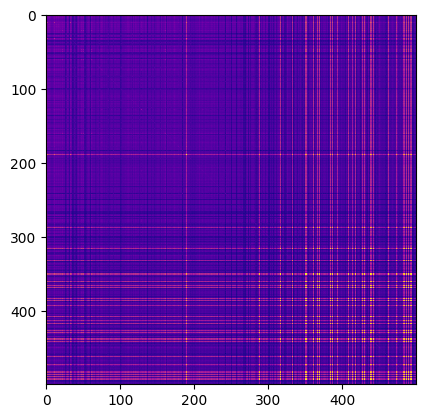

2mer aa Composition Heatmap


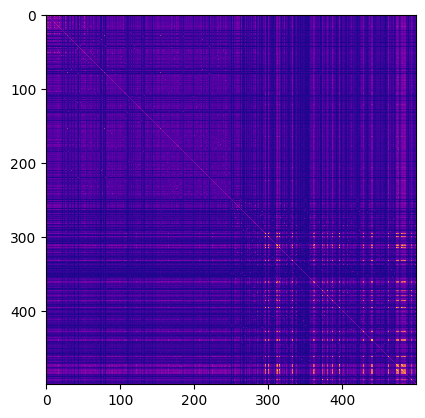

3mer aa Composition Heatmap


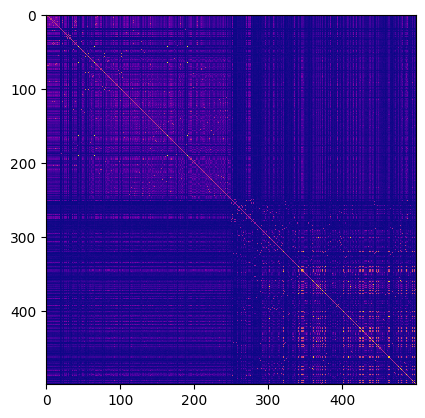

In [7]:
print("1mer aa Composition Heatmap")
X_1_Shuffle = ShuffleAndSampleMatrix(finalOneMerDF, 500)
heatMap = np.matmul(X_1_Shuffle, X_1_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

print("2mer aa Composition Heatmap")
X_2_Shuffle = ShuffleAndSampleMatrix(finalTwoMerDF, 500)
heatMap = np.matmul(X_2_Shuffle, X_2_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

print("3mer aa Composition Heatmap")
X_3_Shuffle = ShuffleAndSampleMatrix(finalThreeMerDF, 500)
heatMap = np.matmul(X_3_Shuffle, X_3_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

<span style="color:lightgreen">

### Part 2 Discussion Heatmap: 

For this analyses, 500 samples were randomly taken from each kmer matrix. Group b.1.1.1 and group b.1.1.0 were both evenly represented with b.1.1.1 being the first 250 and b.1.1.0 being the last 250 of the heat matrix. The dot product of these matrices shows us the similarity between each sequence, with the diagonel representing the maximum similarity (as sequence kmer vectors are compared against themselves). As kmers increase, more distinct patterns and groupings of emerge, but also the 'heat' of the map tends to cool as the chance of sequences having similar chains of amino acids decreases. This trend would continue as we increase kmer length until, when kmer length is equal to sequence length, we would see no similarity.

Without the entire ordered data set it is somewhat difficult to get the full picture of these groupings, but one trend that does show up as kmer size increases is that groups are more similar with themselves than they are with each other. We also see further partitioning and hotspots within groups, which could represent lower order groupings of protein function, ancestry, location, or interaction. 

### Part 3:  performance for reduced alphabets

As the length of a k-mer increases, the dimensionality of the feature space increases.  One way to mitigate that is to use a *reduced alphabet* by grouping together related amino acids.  One such grouping is the following:

Positively charged [H, R, K], 
negatively charged/polar [D, E, N, Q], 
polar/small [S, T, P, A, G], 
hydrophobic/aliphatic [M, I, L, V], and 
hydrophotic/aromatic/large [F, Y, W]; cystein [C] is a special amino acid, and is typically its own group.  This grouping reflects the rates at which amino acids tend to substitute each other over the course of evolution as captured by *substitution matrices* such as the well known Blosum62 matrix shown here (we will cover substitution matrices in detail later in the course):

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Blosum62-dayhoff-ordering.svg" width=400 />

Repeat your experiment from part 2 using the reduced alphabet for varying values of k-mer length and compare the results to those you got in part 2.  What can you conclude?


SVM RBF 1mer Group Data: 	 0.68059181897302
SVM RBF 2mer Group Data: 	 0.7963446475195822
SVM RBF 3mer Group Data: 	 0.8268059181897301
SVM RBF 4mer Group Data: 	 0.8294168842471714
SVM RBF 5mer Group Data: 	 0.8372497824194952


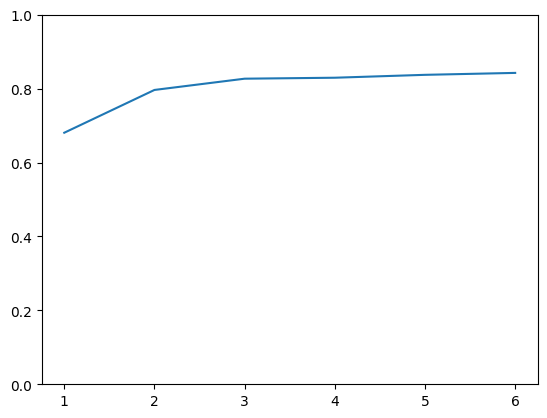

In [8]:
#Estimated Cell Run Time ~14 minutes

#Stripping away feature matrix for X input and the target matrix for y input. Grouped by kMer and data encoding type
X_1G = finalOneMerGroupDF.iloc[:,2:-1]
X_2G = finalTwoMerGroupDF.iloc[:,2:-1]
X_3G = finalThreeMerGroupDF.iloc[:,2:-1]
X_4G = finalFourMerGroupDF.iloc[:,2:-1]
X_5G = finalFiveMerGroupDF.iloc[:,2:-1]
X_6G = finalSixMerGroupDF.iloc[:,2:-1]

YG = finalOneMerGroupDF['SeqFam']

#Train test splits for all the reduced alphabet encoded kmer compositions.
trainX1, testX1, trainY1, testY1 = train_test_split(X_1G, YG, test_size=0.3, random_state=42)
trainX2, testX2, trainY2, testY2 = train_test_split(X_2G, YG, test_size=0.3, random_state=42)
trainX3, testX3, trainY3, testY3 = train_test_split(X_3G, YG, test_size=0.3, random_state=42)
trainX4, testX4, trainY4, testY4 = train_test_split(X_4G, YG, test_size=0.3, random_state=42)
trainX5, testX5, trainY5, testY5 = train_test_split(X_5G, YG, test_size=0.3, random_state=42)
trainX6, testX6, trainY6, testY6 = train_test_split(X_6G, YG, test_size=0.3, random_state=42)

#Initialize an empty list to track accuracy of classifiers for plotting
accuracy = list()
xAx = [1, 2, 3, 4, 5, 6]
xTicks = range(len(xAx))

#Training and predicting standard amino acid composition SVM classifiers.
SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX1, trainY1)
y_pred = SVMRBF.predict(testX1)
accuracy.append(np.mean(testY1 == y_pred))
print('SVM RBF 1mer Group Data: \t', np.mean(testY1 == y_pred))

SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX2, trainY2)
y_pred = SVMRBF.predict(testX2)
accuracy.append(np.mean(testY2 == y_pred))
print('SVM RBF 2mer Group Data: \t', np.mean(testY2 == y_pred))

SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX3, trainY3)
y_pred = SVMRBF.predict(testX3)
accuracy.append(np.mean(testY3 == y_pred))
print('SVM RBF 3mer Group Data: \t', np.mean(testY3 == y_pred))

SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX4, trainY4)
y_pred = SVMRBF.predict(testX4)
accuracy.append(np.mean(testY4 == y_pred))
print('SVM RBF 4mer Group Data: \t', np.mean(testY4 == y_pred))

SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
SVMRBF.fit(trainX5, trainY5)
y_pred = SVMRBF.predict(testX5)
accuracy.append(np.mean(testY5 == y_pred))
print('SVM RBF 5mer Group Data: \t', np.mean(testY5 == y_pred))

# SVMRBF = svm.SVC(kernel="rbf", gamma=0.01, C=1)
# SVMRBF.fit(trainX6, trainY6)
# y_pred = SVMRBF.predict(testX6)
# accuracy.append(np.mean(testY6 == y_pred))
# print('SVM RBF 6mer Group Data: \t', np.mean(testY6 == y_pred))

#Cheat and append the final accuracy without running the SVM...
accuracy.append(0.8424717145343777)

#Plot the accuracy
fig = plt.figure()
ax = plt.axes()
plt.ylim(0, 1)
plt.xticks(xTicks, xAx)
ax.plot(accuracy)


#### Saved Outputs from Above Cell

SVM RBF 1mer Group Data: 	 0.68059181897302

SVM RBF 2mer Group Data: 	 0.7963446475195822

SVM RBF 3mer Group Data: 	 0.8268059181897301

SVM RBF 4mer Group Data: 	 0.8294168842471714

SVM RBF 5mer Group Data: 	 0.8372497824194952

SVM RBF 6mer Group Data: 	 0.8424717145343777

<span style="color:lightgreen">

### Part 3 Discussion

Here, once again, discussion is difficult due to runtime constraints, however it follows much the same logic as the above discussion for aa kmers. The big difference here, however, is that due to the reduced alphabet encoding of kmers (and the smaller feature matrix size), the accuracy curve is shifted to the left; Starting with a less accurate classifier at 1mer groupings, but ending with a similar accuracy to that of the standard aa 3mer encoding. This initial drop is likely due to a compression of data where the classifier has a harder time distinquishing what about each sequence is actually important. This is quickly rescued by the 3 - 4kmer groups, where we're still computing a smaller set of features than aa kmers, but we're retaining enough of the motif information to make accurate classifications. Interestingly, what we don't see in this data set (even as we stretch the length of the feature matrix to incredibly high dimensions) is the decline in accuracy as the length of kmers increases. This is likely just due to where this analyses stopped (6mer) which is 6^6 (46,656 features). We only barely see a decline in classifier accuracy on the above standard aa kmer encoding when we get to 4mer, which is 20^4 or 160,000 features. If we continued we would likely see further and further degredation of classifier accuracy as the features encode increasingly sparse matrices. Testing 6^7 or 20^5 was unfortunately prohibitively computationally intensive. 

**Note:** Part 3 heatmap discussion is at the very bottom of the notebook. 

1mer Group Composition Heatmap


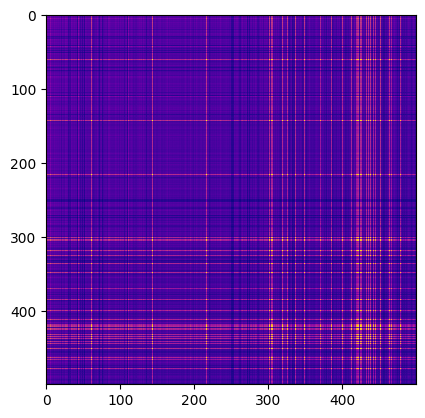

2mer Group Composition Heatmap


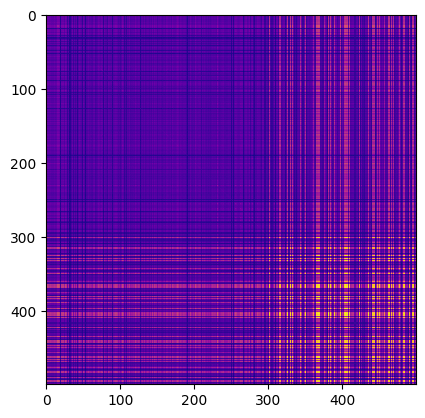

3mer Group Composition Heatmap


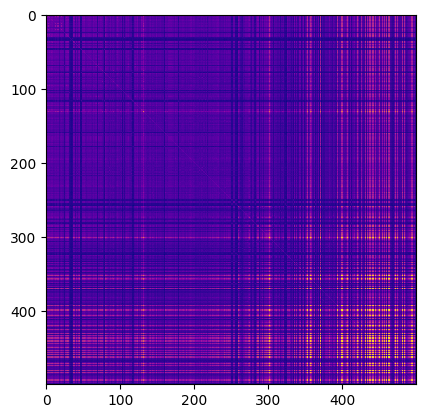

4mer Group Composition Heatmap


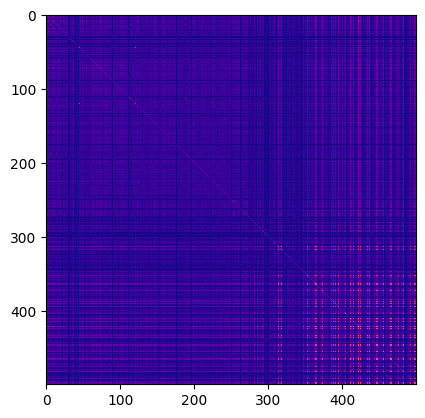

5mer Group Composition Heatmap


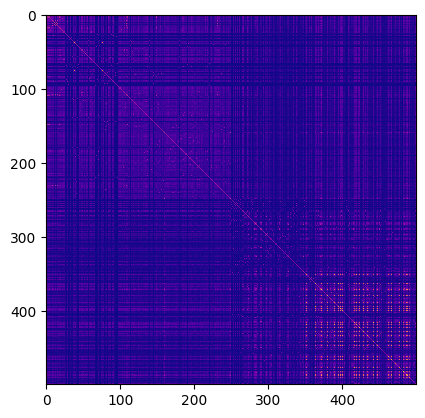

In [9]:
print("1mer Group Composition Heatmap")
X_1G_Shuffle = ShuffleAndSampleMatrix(finalOneMerGroupDF, 500)
heatMap = np.matmul(X_1G_Shuffle, X_1G_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

print("2mer Group Composition Heatmap")
X_2G_Shuffle = ShuffleAndSampleMatrix(finalTwoMerGroupDF, 500)
heatMap = np.matmul(X_2G_Shuffle, X_2G_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

print("3mer Group Composition Heatmap")
X_3G_Shuffle = ShuffleAndSampleMatrix(finalThreeMerGroupDF, 500)
heatMap = np.matmul(X_3G_Shuffle, X_3G_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

print("4mer Group Composition Heatmap")
X_4G_Shuffle = ShuffleAndSampleMatrix(finalFourMerGroupDF, 500)
heatMap = np.matmul(X_4G_Shuffle, X_4G_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

print("5mer Group Composition Heatmap")
X_5G_Shuffle = ShuffleAndSampleMatrix(finalFiveMerGroupDF, 500)
heatMap = np.matmul(X_5G_Shuffle, X_5G_Shuffle.T)        
plt.imshow(heatMap, cmap='plasma', interpolation= 'nearest')
plt.show()

<span style="color:lightgreen">

### Part 3 Discussion Heatmap: 

Repeating the heatmap analyses of aa kmers, we now look at aa groupings. Similarly as well we see great groupings and trends as kmer length increases. Also, due to the compressed nature of this data set the heat map is generally intensified as there is greater chances for similarity when multiple amino acids can encode for the same grouping. This approach, at least with this random data set interestingly showed only minor intra-group relationship for b.1.1.1 and a greatly intensified group relationship of b.1.1.0. Whether this is due to random sampling or the nature of the protein groups would require further analysis. One other area of further analysis that would be interesting is, if the whole data set were computed at higher kmer length levels if the similarities would show the same kinds of sub-groupings mentioned in the above heatmap analysis or if these aa groups would reveal different sub-families of proteins with their relatedness. 